In [23]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from joblib import Memory
from skimage import feature, color, transform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import ml_utilities
import ml_visualization

In [24]:
# Path contenente i pattern di train e test
image_side = 128
db_path = 'DBs/CaniGatti_ML18'
exp_path = 'Experiments'
train_filelist = 'BinaryTrainingSetExp.txt' 
test_filelist = 'Unlabeled_BinaryTestSet.txt'
result_path = 'Es4Predictions.txt'

In [25]:
# Esercizio 2: valutazione su test set
# Caricamento dei pattern di training

memory = Memory(exp_path, verbose=0) 
# Caricamento delle immagini
print('Caricamento in corso ...')
start = time.time()
train_raw_x, train_y = ml_utilities.load_labeled_dataset(train_filelist, db_path )

print('Caricate %d immagini in %.2f s.' % (len(train_raw_x), time.time() - start))
print('Gatti:', np.count_nonzero(train_y == 0))
print('Cani:', np.count_nonzero(train_y == 1))

Caricamento in corso ...
Caricate 748 immagini in 0.58 s.
Gatti: 357
Cani: 391


Resizing in corso ...
Resizing completato in 0.45 s.


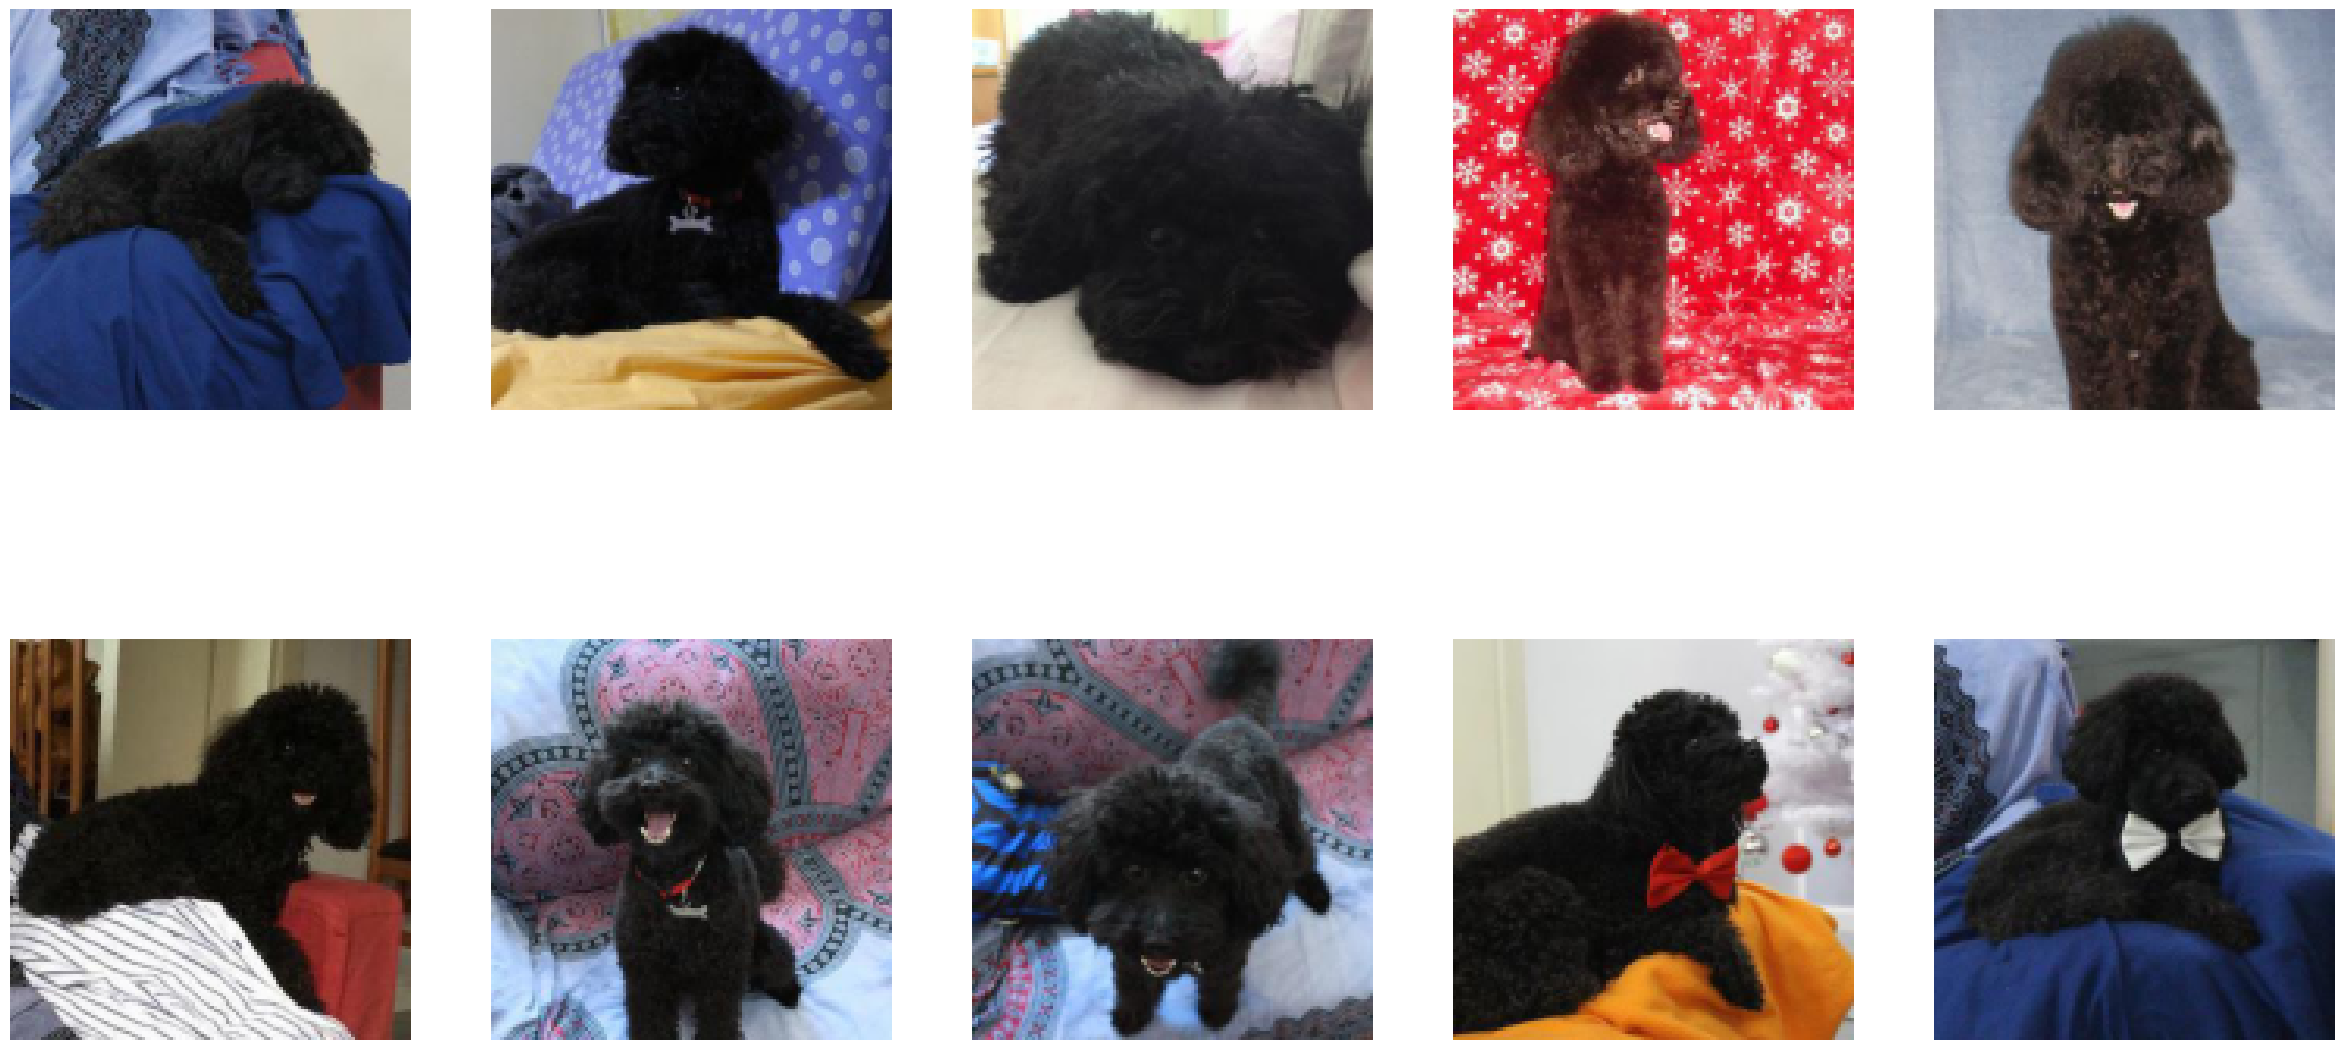

In [26]:
# Resizing delle immagini
resizing = True
image_side = 128

if resizing:
    # Resize
    print('Resizing in corso ...')
    start = time.time()
    train_raw_x = ml_utilities.resize_images(train_raw_x, image_side, image_side, cache=memory)
    
    print('Resizing completato in %.2f s.' % (time.time() - start))
    
    # Visualizzazione immagini
    _, axs = plt.subplots(2, 5,figsize=(30, 15))
    for i in range(5):
        axs[0,i].imshow(train_raw_x[i]),axs[0,i].axis('off')
        axs[1,i].imshow(train_raw_x[5+i]),axs[1,i].axis('off')
    plt.show()

In [27]:
# Preprocessing ed estrazione HOG (training)
print('Estrazione delle feature HOG in corso ...')
start = time.time()
train_feature_x = ml_utilities.extract_hog(train_raw_x, 
                                           convert_to_gray=True, orientations=10,
                                           pixels_per_cell=(18,18), cells_per_block=(1,1),
                                           cache=memory)
print('Estrazione completata in %.2f s.' % (time.time() - start))
print('Numero di feature per immagine:', train_feature_x[0].shape[0])

Estrazione delle feature HOG in corso ...
Estrazione completata in 0.33 s.
Numero di feature per immagine: 490


In [28]:
# Creazione del classificatore
clf = RandomForestClassifier(random_state=1234)

## Grid search
param_grid = {'n_estimators': [10, 50, 100, 200, 500, 750], 'max_depth': [1, 5, 10, 20]}

grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_feature_x, train_y)
# Stampa risultati
print('Combinazioni di parametri:\n', grid_search.cv_results_['params'])
print('Accuratezza media per combinazione:\n', grid_search.cv_results_['mean_test_score'])
print('Combinazione migliore:\n', grid_search.best_params_)
print('Accuratezza media della combinazione migliore: %.3f' % grid_search.best_score_)



Combinazioni di parametri:
 [{'max_depth': 1, 'n_estimators': 10}, {'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 1, 'n_estimators': 200}, {'max_depth': 1, 'n_estimators': 500}, {'max_depth': 1, 'n_estimators': 750}, {'max_depth': 5, 'n_estimators': 10}, {'max_depth': 5, 'n_estimators': 50}, {'max_depth': 5, 'n_estimators': 100}, {'max_depth': 5, 'n_estimators': 200}, {'max_depth': 5, 'n_estimators': 500}, {'max_depth': 5, 'n_estimators': 750}, {'max_depth': 10, 'n_estimators': 10}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 200}, {'max_depth': 10, 'n_estimators': 500}, {'max_depth': 10, 'n_estimators': 750}, {'max_depth': 20, 'n_estimators': 10}, {'max_depth': 20, 'n_estimators': 50}, {'max_depth': 20, 'n_estimators': 100}, {'max_depth': 20, 'n_estimators': 200}, {'max_depth': 20, 'n_estimators': 500}, {'max_depth': 20, 'n_estimators': 750}]
Accuratezza media per combinazi

In [29]:
# Addestramento del classificatore
print('Addestramento in corso ...')

start = time.time()
clf = grid_search.best_estimator_
#clf = AdaBoostClassifier(n_estimators=100, estimator=RandomForestClassifier(max_depth=13, bootstrap=False, criterion='gini'))
clf.fit(train_feature_x, train_y)
print('Addestramento completato in %.2f s.' % (time.time() - start))



Addestramento in corso ...
Addestramento completato in 2.95 s.


In [30]:
# Caricamento dei pattern di test
test_raw_x = ml_utilities.load_unlabeled_dataset(test_filelist, db_path, cache=memory)

In [31]:
# Resizing delle immagini
resizing = True
image_side = 128

if resizing:
    # Resize
    print('Resizing in corso ...')
    start = time.time()
    test_raw_x = ml_utilities.resize_images(test_raw_x, image_side, image_side, cache=memory)
    
    print('Resizing completato in %.2f s.' % (time.time() - start))

Resizing in corso ...
Resizing completato in 0.08 s.


In [32]:
# Preprocessing ed estrazione HOG (test)

print('Estrazione delle feature HOG in corso ...')
start = time.time()
test_feature_x = ml_utilities.extract_hog(test_raw_x, 
                                          convert_to_gray=True, orientations=10,
                                          pixels_per_cell=(18,18), cells_per_block=(1,1),
                                          cache=memory)

Estrazione delle feature HOG in corso ...


In [33]:
# Salvataggio delle predictions
predictions = clf.predict(test_feature_x)

with open(result_path, "w") as f:
    for prediction in predictions:
        f.write(str(int(prediction)) + '\n')
print('Ok')

Ok
